# 情報活用講座：　ケモインフォマテックス 編　
# 第6回：　BRICSを使った構造生成と仮想分子ライブラリ

## 底本
船津 公人、柴山 翔二郎 **『実践 マテリアルズインフォマティクス　Pythonによる材料設計のための機械学習』**、近代科学社、2020  
第８章　8.1.2　RECAPとBRICSを利用した構造生成  
第９章　9.3.1　並列処理を用いた構造生成


## データセット
delaney-processed.csvは1128化合物の水溶解度についてのデータセットです。このデータセットは、Delaneyの論文『ESOL: Estimating Aqueous Solubility Directly from Molecular Structure』[1] で発表されたものに基づいています。

[1] John S. Delaney, "ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure", J. Chem. Inf. Comput. Sci. 44, 1000–1005 (2004) (DOI: 10.1021/ci034243x)  

Delaney-processed.csvは、分子の化学式、SMILES表記、また、水溶解度としてオクタノール水分配係数が含まれており、これらの特性は薬物探索や環境影響評価などの目的で使用されています。


1. Compound ID	：化合物ID
1. ESOL predicted log solubility in mols per litre　：log水溶解度（オクタノール水分配係数）の予測値	
1. Minimum Degree：　最小次数	
1. Molecular Weight：分子量	
1. Number of H-Bond Donors	：　水素結合に関与するDonor数
1. Number of Rings	：芳香環の数	
1. Number of Rotatable Bonds　：　回転可能結合数	
1. Polar Surface Area　：　極性表面積	
1. measured log solubility in mols per litre：log水溶解度の実測値	
1. smiles：SMILES表記


## pythonライブラリ


**NumPy**：　高性能の数値計算やデータ処理に特化したPythonのライブラリです。NumPyは多次元の配列や行列を効率的に操作する機能を提供し、科学技術計算やデータ解析の分野で広く使用されています。

**Pandas**：　データ操作と解析のための高レベルのPythonライブラリです。Pandasは、テーブル形式のデータを効率的に処理し、データのフィルタリング、変換、集約、および結合などの機能を提供します。データの整形やクリーニング、欠損値の処理などを容易に行うことができます。

**Matplotlib**：　Pythonでデータを可視化するための強力なライブラリです。Matplotlibは、グラフや図を描画するための多様な機能を提供し、折れ線グラフ、ヒストグラム、散布図、バーチャートなどの多くのプロットスタイルをサポートしています。データの傾向や関係性を視覚的に理解するための強力なツールです。

**RDKit**：　RDKitは、化学情報学や薬学の分野で広く使用されるオープンソースのソフトウェア開発キットです。RDKitはPythonで実装されており、様々な化学情報の処理や分子の構造解析、化学反応の予測などをサポートします。

## 目標

1. 分子のフラグメント化アルゴリズムである**BRICS（Breaking of Retrosynthetically Interesting Chemical Substructures)** [2]を使い、仮想的な分子ライブラリを作成します。

1. 目的物性値を持つトレーニングデータを用いて機械学習モデルとモデルの適用範囲を測るモデルを作成し、そのモデルによるスクリーニングを行います。

BRICSを使った分子の構造生成についてPythonで学ぶポイントを以下にまとめました。


* BRICSの適用: RDKitの`rdkit.Chem.BRICS.BRICSDecompose()`メソッドを使用して、BRICSを適用し分子を分解します。このメソッドは、分解された部分構造のジェネレータを返します。

* 生成された部分構造の操作: 分解された部分構造は、Pythonのリストとして取得できます。これらの部分構造を組み合わせて新しい分子を作成するために、必要な操作を実行できます。例えば、部分構造を結合したり、部分構造を変更したりすることができます。

* 新しい分子の生成: 部分構造の組み合わせに基づいて、`rdkit.Chem.BRICS.BRICS.BRICSBuild()`メソッドから新しい分子を生成します。


[2] Jörg Degen, Christof Wegscheid-Gerlach, Andrea Zaliani, Matthias Rarey, 「On the Art of Compiling and Using ‘Drug‐Like’ Chemical Fragment Spaces」, ChemMedChem, 3, 1503. 2008. (DOI:10.1002/cmdc.200800178)

# Google Colabにおける環境設定
google colab環境でなければ実行不要

In [ ]:
!pip install rdkit-pypi
!git clone https://github.com/ARIM-Training/Training_python_4.git
%cd Training_python_4

## 1.分子構造データの読み込み （底本 P.99）
### 汎用ライブラリのインポート

In [2]:
import pandas as pd 
import numpy as np

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

from warnings import filterwarnings
filterwarnings('ignore')# 警告を無視

### サンプルファイルの読み込み

ここでもdelaney-processed.csvを使います。pandasの`read_csv()`からデータフレーム（DataFrame）オブジェクトとして変数dfに格納します。

In [3]:
df = pd.read_csv('./data/delaney-solubility/delaney-processed.csv')
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


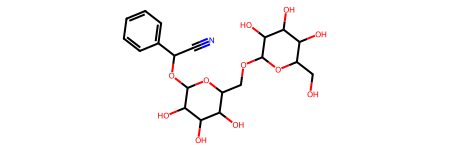

In [5]:
df['mol'][0]

## 2.BRICSによる分子ライブラリの作成

 BRICSを使用するためには、RDKitでBRICSモジュールを読み込む必要があります。以下のコードを使用して、`BRICS`モジュールをインポートします。

In [7]:
from rdkit.Chem import BRICS

### フラグメント化（部分構造化）

RDKitの`BRICS.BRICSDecompose()`メソッドは、分子をBRICS (Bristol-Myers Squibb Reaction-Inspired Clustering System) 法に基づいてフラグメント化するための機能を提供します。
`BRICSDecompose()`によって、元の分子が複数のフラグメントに分割され、それぞれのフラグメントが独立した化学構造となります。なお、デフォルトでは切断位置にダミーアトムを挿入して表示されます。

化合物IDゼロ番目をフラグメント化させると、6つに分解されることがわかります。

In [8]:
frag0 = BRICS.BRICSDecompose(df['mol'][0])
frag0

{'[13*]C1OC([13*])C(O)C(O)C1O',
 '[16*]c1ccccc1',
 '[3*]O[3*]',
 '[4*]C([8*])C#N',
 '[4*]C[8*]',
 '[8*]CO'}

In [9]:
 len(frag0)

6

`BRICSDecompose()`の引数で`returnMols`オプションでTrueを指定しフラグメントをMol化させておくと、`MolsToGridImage()`関数で視覚化することが楽になります。上記の6つの部分骨格は、次のような構成になっています。

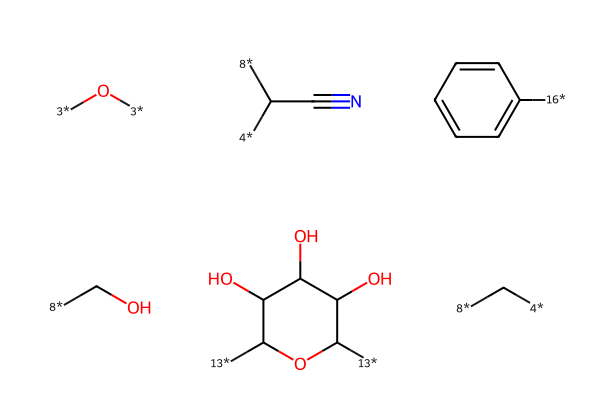

In [10]:
frag0_mols = BRICS.BRICSDecompose(df['mol'][0], returnMols=True)
Draw.MolsToGridImage(frag0_mols, molsPerRow=3)

【練習】別分子のフラグメント化を見てみることにしましょう。

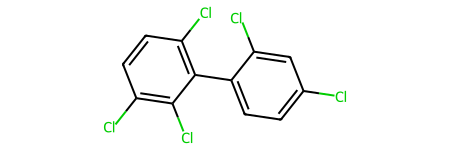

In [11]:
df['mol'][20]

In [12]:
frag20 = BRICS.BRICSDecompose(df['mol'][20])
frag20

{'[16*]c1c(Cl)ccc(Cl)c1Cl', '[16*]c1ccc(Cl)cc1Cl'}

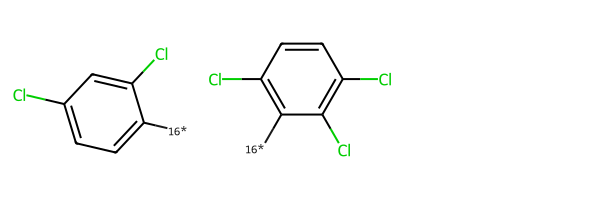

In [13]:
frag20_mols = BRICS.BRICSDecompose(df['mol'][20], returnMols=True)
Draw.MolsToGridImage(frag20_mols, molsPerRow=3)

### フラグメントライブラリ作成
上記は1分子でのフラグメントの方法でした。次はdelaney-processed.csvにある1128分子のフラグメント化を行い、重複のない固有のフラグメントをリストとしてライブラリ化してみましょう。

まず、三項演算子を使い、df['mol']を逐次、`BRICSDecompose()`関数へmolという変数で受け渡し、`list()`関数でリスト配置をとらせます。

In [14]:
fragments = [list(BRICS.BRICSDecompose(mol)) for mol in df['mol']]
fragments

[['[3*]O[3*]',
  '[4*]C([8*])C#N',
  '[8*]CO',
  '[13*]C1OC([13*])C(O)C(O)C1O',
  '[4*]C[8*]',
  '[16*]c1ccccc1'],
 ['[16*]c1ccoc1C', '[16*]c1ccccc1', '[1*]C([6*])=O', '[5*]N[5*]'],
 ['[7*]CC=O', '[7*]C(C)C', '[7*]CCCC([7*])C'],
 ['c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21'],
 ['c1ccsc1'],
 ['c1ccc2scnc2c1'],
 ['[16*]c1c(Cl)cccc1Cl', '[16*]c1c(Cl)cc(Cl)cc1Cl'],
 ['CC12CCC3c4ccc(O)cc4CCC3C1CCC2O'],
 ['ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl'],
 ['[16*]c1cc2c(cc1[16*])C1C(=O)c3ccc4c(c3OC1CO2)CC(C(=C)C)O4', '[3*]OC'],
 ['O=C1CCCN1'],
 ['Clc1ccc2ccccc2c1'],
 ['C=CCCC'],
 ['[15*]C1([15*])C(=O)NCNC1=O', '[16*]c1ccccc1', '[8*]CC'],
 ['CCCCCCCCCCCCCC'],
 ['CC(C)Cl'],
 ['CCC(C)CO'],
 ['N#Cc1ccccc1'],
 ['[14*]c1cc(C)nc([14*])n1', '[8*]C(C)C', '[4*]CC', '[3*]OP(=S)(O[3*])O[3*]'],
 ['CCCCCCCCCC(C)O'],
 ['[16*]c1ccc(Cl)cc1Cl', '[16*]c1c(Cl)ccc(Cl)c1Cl'],
 ['[9*]n1c(=O)[nH]c2c(c1=O)CCC2', '[15*]C1CCCCC1'],
 ['[4*]CC', '[3*]OP(=S)(O[3*])SCS[11*]'],
 ['[3*]O[3*]', '[4*]CC', '[1*]C(C)=O', '[16*]c1ccc([

In [15]:
len(fragments)

1128

このように1128分子のネスト化されたリスト構造となっています。ネストを解消させてフラグメントのリスト構造とする方法として、次のような`unwrap`関数を準備します。

In [16]:
def unwrap(list_data):
    list_output = []
    for li in list_data: 
        list_output += li
    return list_output

unwrap関数にかけると、フラグメントの総数は2315のパーツであることがわかります。

In [17]:
fr_all = unwrap(fragments)
fr_all

['[3*]O[3*]',
 '[4*]C([8*])C#N',
 '[8*]CO',
 '[13*]C1OC([13*])C(O)C(O)C1O',
 '[4*]C[8*]',
 '[16*]c1ccccc1',
 '[16*]c1ccoc1C',
 '[16*]c1ccccc1',
 '[1*]C([6*])=O',
 '[5*]N[5*]',
 '[7*]CC=O',
 '[7*]C(C)C',
 '[7*]CCCC([7*])C',
 'c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21',
 'c1ccsc1',
 'c1ccc2scnc2c1',
 '[16*]c1c(Cl)cccc1Cl',
 '[16*]c1c(Cl)cc(Cl)cc1Cl',
 'CC12CCC3c4ccc(O)cc4CCC3C1CCC2O',
 'ClC1=C(Cl)C2(Cl)C3C4CC(C5OC45)C3C1(Cl)C2(Cl)Cl',
 '[16*]c1cc2c(cc1[16*])C1C(=O)c3ccc4c(c3OC1CO2)CC(C(=C)C)O4',
 '[3*]OC',
 'O=C1CCCN1',
 'Clc1ccc2ccccc2c1',
 'C=CCCC',
 '[15*]C1([15*])C(=O)NCNC1=O',
 '[16*]c1ccccc1',
 '[8*]CC',
 'CCCCCCCCCCCCCC',
 'CC(C)Cl',
 'CCC(C)CO',
 'N#Cc1ccccc1',
 '[14*]c1cc(C)nc([14*])n1',
 '[8*]C(C)C',
 '[4*]CC',
 '[3*]OP(=S)(O[3*])O[3*]',
 'CCCCCCCCCC(C)O',
 '[16*]c1ccc(Cl)cc1Cl',
 '[16*]c1c(Cl)ccc(Cl)c1Cl',
 '[9*]n1c(=O)[nH]c2c(c1=O)CCC2',
 '[15*]C1CCCCC1',
 '[4*]CC',
 '[3*]OP(=S)(O[3*])SCS[11*]',
 '[3*]O[3*]',
 '[4*]CC',
 '[1*]C(C)=O',
 '[16*]c1ccc([16*])cc1',
 '[5*]N[5*]',
 '[16*]c1

In [18]:
len(fr_all)

2315

フラグメントでは重複するものがありますので、ここでは`set()`関数を使って、一意のフラグメントの集合をつくります。下記のように実行するとフラグメント数として1028となりました。すなわち約半分が重複していたことになります。

In [19]:
frag_library = set(fr_all)
frag_library 

{'Clc1ccccc1',
 '[16*]c1cc(O)c(O)c(O)c1',
 'C=CCCC',
 'CN1C(=O)CN=C(c2ccccc2)c2cc(Cl)ccc21',
 '[12*]S(=O)(=O)c1ccc(N)cc1',
 'Fc1cccc(F)c1',
 'Cc1ccccc1C',
 '[14*]c1nc(C)c([16*])c(O)n1',
 '[11*]SS(=O)CC=C',
 'CC(C)(C)CO',
 '[13*]C1COC([13*])([13*])O1',
 'c1cncnc1',
 'CC12CCC3C(CCC4CC(=O)CCC43C)C1CCC2O',
 '[16*]c1cccc2ccccc12',
 'CCCC(=O)CCC',
 '[4*]CC#CCCl',
 '[16*]c1ccc(C)cc1O',
 '[16*]c1ccc(S(C)=O)cc1',
 'O=C1NC(=O)c2ccccc21',
 'NC(N)=O',
 'O=C1CCCN1',
 '[3*]OC1=CC(=O)CC(C)(C)C1',
 'CC(C)Br',
 'Nc1nc(=O)[nH]cc1F',
 'Cc1ccccc1',
 'CCC#CCC',
 '[16*]c1ccc([16*])c(Cl)c1',
 'c1ccc2c(c1)ccc1c2ccc2c3ccccc3ccc21',
 '[10*]N1CC(=O)N([10*])C1=O',
 '[11*]SS[11*]',
 '[8*]CO',
 'Brc1ccccc1',
 '[14*]c1nc2ccccc2s1',
 'CCCCCCCI',
 'ClCCBr',
 'CC12CCC3C(CCC4=CC(=O)CCC43C)C1CCC2=O',
 'Cc1ccccc1[N+](=O)[O-]',
 'N#Cc1ccccc1C#N',
 'Cc1ccc2ccccc2c1',
 'C#CCCCCC',
 '[4*]C(C)(C)CCCC(C)CC[7*]',
 '[7*]C(Cl)C(F)(F)F',
 '[4*]C1([15*])C(C)CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC21C',
 'CCCC(O)CC',
 'O=C1C2(Cl)C3(Cl)C4(

In [20]:
print('BRICSが取り出した全フラグメント', len(set(fr_all)))

BRICSが取り出した全フラグメント 1028


### 部分構造の指定
フラグメント化された構造の一部を確認しましょう。frag_libraryのSMILESをMolオブジェクトに変換したものをlist_fragmentsに格納します。

In [21]:
list_fragments = [Chem.MolFromSmiles(smi) for smi in frag_library]

seed_structures = list_fragments[:2]
print(len(seed_structures))

2


フラグメントの最初の2つの構造を描画したものを表示させます。（実行ごとにランダムに変化します）

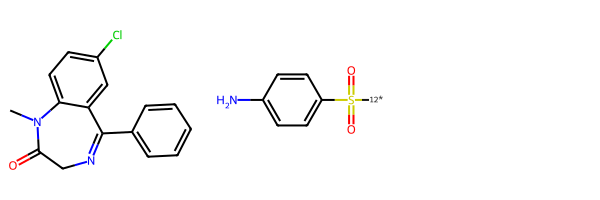

In [22]:
Draw.MolsToGridImage(seed_structures)

### 構造生成によるバーチャルライブラリーの構築

生成されたフラグメントを利用して元の化合物以外の新しい化合物を生成し、「仮想ライブラリ」を作成します。

**構造生成（Structure Generation）**:  
構造生成は、特定の条件や性質を満たす新しい化合物をコンピュータ上で生成するプロセスを指します。化学的に妥当な構造を効率的に生成することは、薬物設計や材料科学などの分野で重要です。フラグメントを組み合わせて新しい化合物の構造生成が行えますが、`BRICS.BRICSBuild()`関数を用いると、部分構造化されたフラグメントをコンピューター上で機械的に組み合わせて新しい構造を生成することが簡単にできます。

**仮想ライブラリ（Virtual Library）**:  
仮想ライブラリとは、化学的に実際に合成されていないが、理論的には存在し得る全ての化合物の集合を指します。仮想ライブラリを用いることで、実験室で合成するのは困難な大規模な化合物集合を網羅的に探索し、有望な化合物を同定することが可能です。また、仮想ライブラリを使うことで、既知の活性を持つ化合物の拡張や、新しい化合物の探索が進められます。

### BRICSBuild()のデフォルト設定での構造生成
frag_libraryのSMILESをMolオブジェクトに変換したものをcomponent変数として格納します。それを`BRICSBuild()`関数で機械的に構造生成を行いbuild変数に格納します。buildのデータ形式はジェネレーターです。

In [21]:
component = [Chem.MolFromSmiles(smi) for smi in frag_library]
build = BRICS.BRICSBuild(component) 

In [22]:
build

<generator object BRICSBuild at 0x000002506A57C0B0>

【解説】`BRICS.BRICSBuild()` メソッド

`BRICS.BRICSBuild()` メソッドは、フラグメントされたMOLオブジェクトのリストから、新しい化合物を生成する方法を提供します。
使用法は以下のようになります：

```python
BRICS.BRICSBuild(mol seeds = seed_structures, maxDepth = 3)
```

引数:
- `mol`: RDKitのMolオブジェクトで、分割対象となる化合物を表します。
- `seeds` (オプション): 構造生成で必ず含むフラグメントを指定します。
- `maxDepth` (オプション): 結合回数を指定します。

戻り値:
`BRICS.BRICSBuild()` は、新しい構造生成の化合物をからなるMolオブジェクトのジェネレータを返します。


分割された部分構造を統合することで、元の化合物とは異なる新しい化合物が得られます。

上記のbuildに収まっている構造生成された化合物はジェネレータ型で保持されていますので、それを次のように`next()`関数を使って逐次的に呼び出してゆきます。この時、`UpdatePropertyCache()`関数で構造が適正であるかをチェックします。そのチェックを通ったものを`append()`メソッドで、generated_molsのオブジェクトとして格納します。
このgenerated_molsの新しく構造生成された分子集合が「仮想ライブラリ」となります。

In [23]:
### 分子1000個を作成
generated_mols = []

for i in range(1000):
    m = next(build)
    m.UpdatePropertyCache(strict=True)
    generated_mols.append(m)

得られた1000化合物の仮想化合物のうち、90化合物を表示してみましょう。

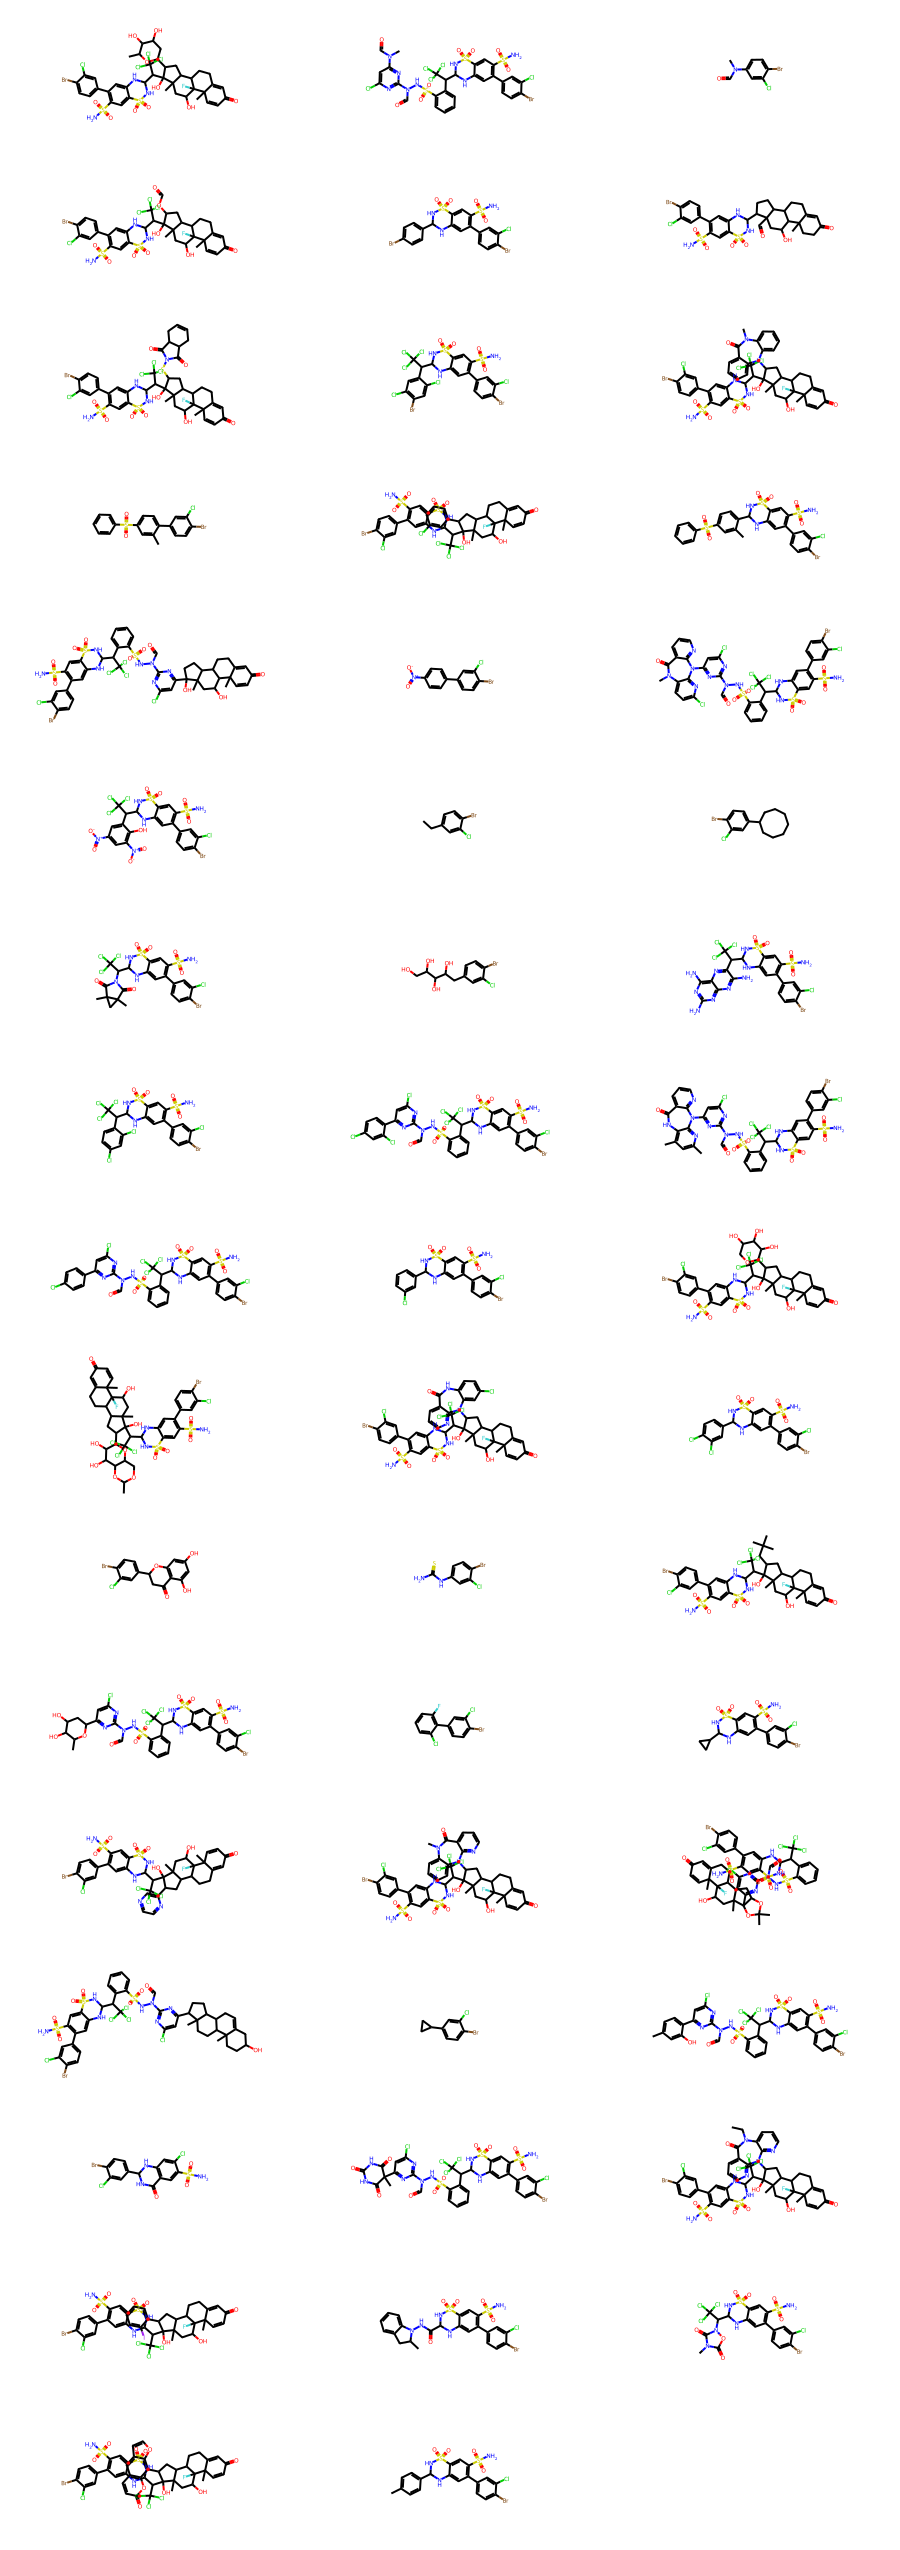

In [24]:
np.random.seed(1234)
np.random.shuffle(generated_mols)

Draw.MolsToGridImage(generated_mols[:90], molsPerRow=3, subImgSize=(300,150))

### 【参考】BRICSBuild()の特定のフラグメントを包含させる
ここでは、BRICSBuild()のオプションであるseedsで必須とするフラグメントを指定し、結合回数を３回とすることで仮想ライブラリを作成する事例です。材料開発で、必ず含ませる必要がある置換基や芳香族ユニットがある場合には、このようなフラグメントを指定することでターゲット化合物を効率的に生成させることができます。

In [25]:
build2 = BRICS.BRICSBuild(component, seeds = seed_structures, maxDepth = 3)

In [26]:
### 分子1000個を作成
generated_mols = []
for i in range(1000):
    m = next(build2)
    m.UpdatePropertyCache(strict=True)
    generated_mols.append(m)

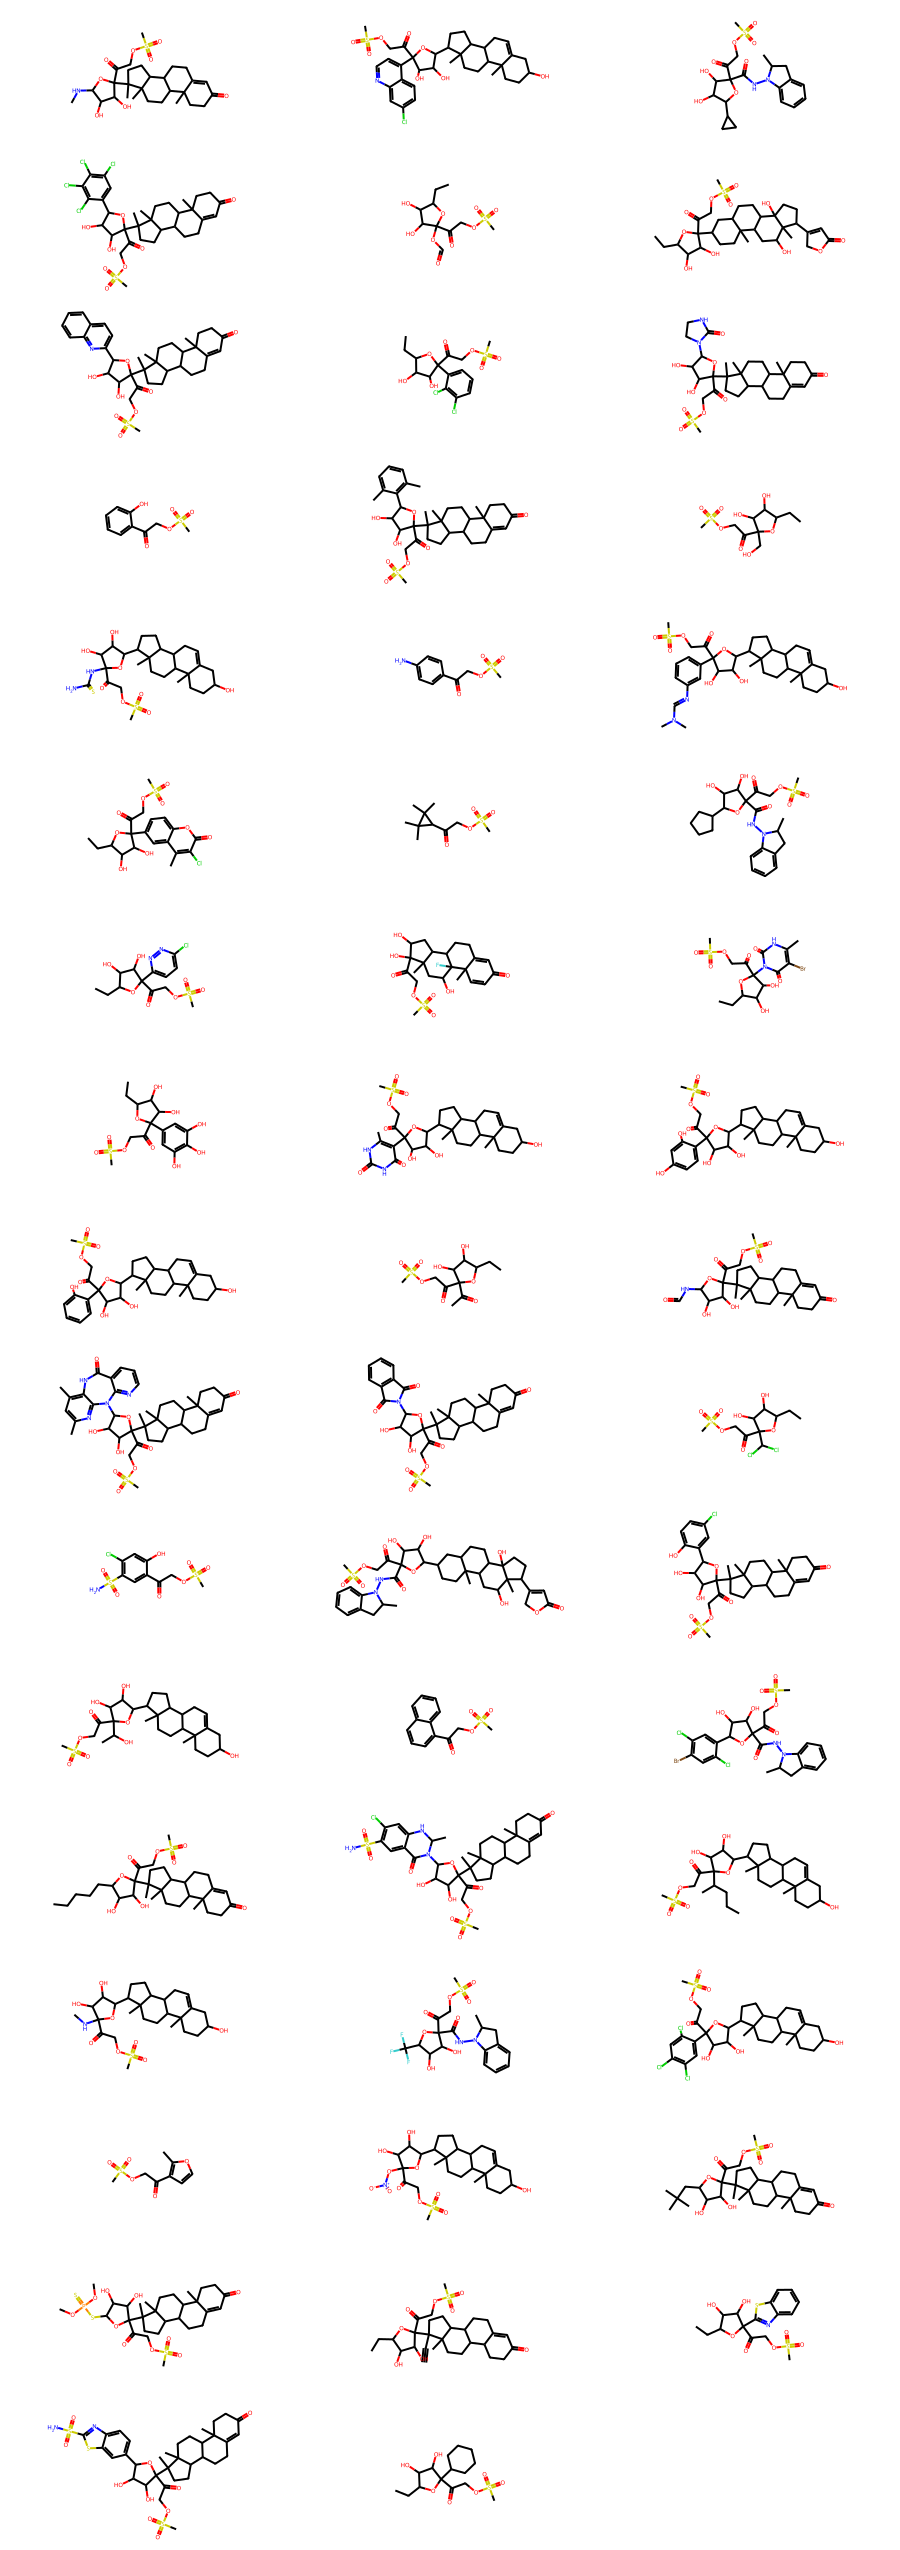

In [27]:
import numpy as np
import random

np.random.seed(1234)
np.random.shuffle(generated_mols)
Draw.MolsToGridImage(generated_mols[:90], molsPerRow=3, subImgSize=(300,150))

## 3.構造生成とファイル保存　(底本P.125)

底本では構造生成数を10万としていますが、ここでは1万と変更しています。構造生成を逐次処理とmultiprocessingによる並列処理とで行い、その処理時間について`time`関数を使って比較を行います。
なお、並列計算はJupyter Notebookでは作動しないが、Google Colabでは動作することに留意。

In [23]:
from random import seed
from time import time
from multiprocessing import Pool

### 逐次処理

In [32]:
NUM_ITER=10000

start = time()
seed(20200315)

builder = BRICS.BRICSBuild(fragments)

with open('./results/mol_single.smi', 'w') as f:
    for i in range(NUM_ITER):
        m = next(builder)
        m.UpdatePropertyCache(strict=True)
        
        smi = Chem.MolToSmiles(m)
        f.write(smi+'\n')
        
print('Elapsed time', stopwatch(start), '[mins]')

Elapsed time 1.1222719152768452 [mins]


### 並列処理
留意：Jupyter Notebookでは作動しません。Google Colabでのときのみ処理を行うようにしてください。

In [ ]:
NUM_ITER=10000

start2 = time()
seed(20200315)

c = 0

builder = BRICS.BRICSBuild(fragments)

with Pool(4) as p:
    f = open('./results/mol_quad.smi', 'w')
    
    for smi in p.imap(func=sample_molecule, iterable=builder, chunksize=100):
        f.write(smi+'\n')
        c+=1
        if c == NUM_ITER:
            print(c)
            break
    f.close()
    
print('Elapsed time', stopwatch(start2), '[mins]')